In [61]:
import os, sys, glob, math, csv

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gpflow
DATAHOME = '/home/staff1/ctorney/data/wildebeest_front/'

/home/staff1/ctorney/python3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Step 1: Select long tracks
First we're going to extract 10000 tracks from the full dataset that are at least 59 seconds long (clips are split into 1 minute segments and 2 frames are required before a detection is confirmed).

In [156]:

##########################################################################
##          movie files and parameters
##########################################################################

inputname = DATAHOME + '/wildfront.csv'
dfMovies = pd.read_csv(inputname)

## remove the IR clips for now
dfMovies = dfMovies[dfMovies['ir']==0]
beestList = np.zeros(shape=(0,3))
##########################################################################
##          loop through movies in list
##########################################################################
for index, d in dfMovies.iterrows():
    
    filename = DATAHOME + d['filename']
    

    direct, ext = os.path.split(filename)
    noext, _ = os.path.splitext(ext)
    inputdatafile = direct + '/proc/' +  noext + '_POS.txt'
    data = np.genfromtxt(inputdatafile,delimiter=',') #,dtype=None, names=True)
    
    
    
    timepoints=data[:,0]
    w_ids=(data[:,1])
    
    # loop over each minute in the file (timesteps correspond to 0.25s or 4fps)
    for i in range(int(np.max(timepoints)//(4*60))):
        indexes = (timepoints>(i*4*60))&(timepoints<((i+1)*4*60))
        t_w_id = w_ids[indexes]
        t_tp = timepoints[indexes]
        for w in np.unique(t_w_id):
            length = np.max(t_tp[t_w_id==w])-np.min(t_tp[t_w_id==w])
            #if long enough store the movie id, the minute and the wildebeest
            if length>(59*4):
                beestList=np.append(beestList,np.array([[index,i,w]]),axis=0)
                #count+=1
        
# save a random subset of 10000 tracks 
beest10000i = np.random.choice(beestList.shape[0], min(1000,len(beestList)), replace=False)
beest10000i = np.sort(beest10000i)
beest10000 = beestList[beest10000i,:]
np.save('beest10000.npy',beest10000)

## Step 2: Gaussian Process for smoothing trajectories
Next we're going to fit a GP to 200 sample trajectories

In [50]:
beest10000=np.load('beest10000.npy')
beest200i = np.random.choice(beest10000.shape[0], min(200,len(beest10000)), replace=False)
beest200i = np.sort(beest200i)
beest200 = beest10000[beest200i,:]

dfMovies = pd.read_csv('/home/staff1/ctorney/data/wildebeest_front/wildfront.csv')
dfMovies = dfMovies[dfMovies['ir']==0]

bcount=0
tcoord = np.zeros((0))
xcoord = np.zeros((0))
ycoord = np.zeros((0))
wcoord = np.zeros((0))
for index, d in dfMovies.iterrows():
    
    filename = DATAHOME + d['filename']
    direct, ext = os.path.split(filename)
    noext, _ = os.path.splitext(ext)
    inputdatafile = direct + '/proc/' +  noext + '_POS.txt'
    data = np.genfromtxt(inputdatafile,delimiter=',') #,dtype=None, names=True)
    BLfile = direct + '/proc/' +  noext + '_BL.npy'
    bodylengths = np.load(BLfile)
    
    
    thisFile = beest200[beest200[:,0]==index]
    count=0
    timepoints=data[:,0]
    w_ids=(data[:,1])
    xpos = 0.5*(data[:,2]+data[:,4])
    ypos = 0.5*(data[:,3]+data[:,5])
    
    for i in range(int(np.max(timepoints)//(4*60))):
        indexes = (timepoints>(i*4*60))&(timepoints<((i+1)*4*60))
        t_w_id = w_ids[indexes]
        t_tp = timepoints[indexes]
        t_xp = xpos[indexes]
        t_yp = ypos[indexes]
        bl = bodylengths[i]
        beestList = beest200[(beest200[:,0]==index)&(beest200[:,1]==i),2]
        for b in beestList:
            
            beestTime = t_tp[t_w_id==b]
            beestX = t_xp[t_w_id==b]/bl
            beestY = t_yp[t_w_id==b]/bl
            beestX = beestX - np.mean(beestX)
            beestY = beestY - np.mean(beestY)
            tcoord = np.hstack((tcoord, beestTime.T))
            xcoord = np.hstack((xcoord, beestX))
            ycoord = np.hstack((ycoord, beestY))
            wcoord = np.hstack((wcoord, bcount*np.ones_like(beestTime)))
            bcount+=1




In [111]:
#stretch out so tracks are independent
T1 = tcoord+wcoord*1000
T1 = T1.reshape(len(T1),1)
X1 = xcoord.reshape(len(xcoord),1)
Y1 = ycoord.reshape(len(ycoord),1)
XY = np.hstack((Y1,X1))

#plt.plot(t2,xcoord)
#plt.axis([100400,100800,-2,2])

M=20
Z = T1[::M, :].copy()
XY = np.hstack((Y1,X1))


## fit the GP
k = gpflow.kernels.RBF(input_dim=1)#,active_dims=[0,1])

m = gpflow.models.SGPR(T1, XY, kern=k,Z=Z)


gpflow.train.ScipyOptimizer().minimize(m)
print(m.as_pandas_table())

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -14208.855244
  Number of iterations: 1000
  Number of functions evaluations: 1203
                              class prior transform  trainable      shape  \
SGPR/kern/variance        Parameter  None       +ve       True         ()   
SGPR/kern/lengthscales    Parameter  None       +ve       True         ()   
SGPR/likelihood/variance  Parameter  None       +ve       True         ()   
SGPR/feature/Z            Parameter  None    (none)       True  (2266, 1)   

                          fixed_shape  \
SGPR/kern/variance               True   
SGPR/kern/lengthscales           True   
SGPR/likelihood/variance         True   
SGPR/feature/Z                   True   

                                                                      value  
SGPR/kern/variance                                       1.5963247503571127  
SGPR/kern/lengthscales               

/home/staff1/ctorney/python3/lib/python3.6/site-packages/gpflow/logdensities.py:89: UserWarning: Shape of x must be 2D at computation.
  warnings.warn('Shape of x must be 2D at computation.')


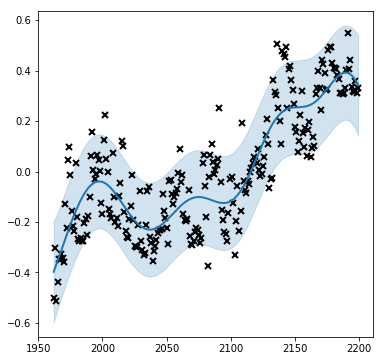

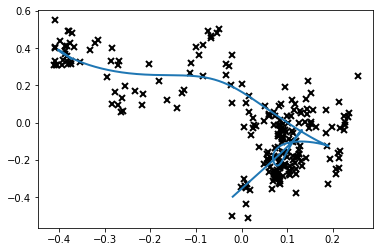

In [110]:
kl = 35.35284062499371
kv = 1.5963247503571127
lv = 0.03332870186146018
k3 = gpflow.kernels.RBF(input_dim=1,lengthscales=kl, variance=kv,ARD=False)
w=1
xa = X1[wcoord==w].astype(np.float64)
ya = Y1[wcoord==w].astype(np.float64)
xya = np.hstack((xa,ya))
ta = T1[wcoord==w]


m1 = gpflow.models.GPR(ta,xya, k3)#=m.Z.value)
m1.likelihood.variance = lv


xx = np.linspace(min(ta), max(ta), 1000).reshape(1000, 1)
mean, var = m1.predict_y(xx)
plt.figure(figsize=(6, 6))
plt.plot(ta, ya, 'kx', mew=2)

plt.plot(xx, mean[:,1], 'C0', lw=2)
plt.fill_between(xx[:,0],
                 mean[:,1] - np.sqrt(var[:,1]),
                 mean[:,1] + np.sqrt(var[:,1]),
                 color='C0', alpha=0.2)
#plt.axis('equal')
plt.show()

plt.plot(xa, ya, 'kx', mew=2)

plt.plot(mean[:,0], mean[:,1], 'C0', lw=2)

#plt.axis('equal')
plt.show()

## Step 3: Smooth trajectories, calculate accelerations and neighbours

In [139]:
beest10000=np.load('beest10000.npy')
##########################################################################
##          movie files and parameters
##########################################################################
DATAHOME = '/home/staff1/ctorney/data/wildebeest_front/'
inputname = DATAHOME + '/wildfront.csv'
dfMovies = pd.read_csv(inputname)


kl = 35.35
kv = 1.596
lv = 0.03333
gpKern = gpflow.kernels.RBF(input_dim=1,lengthscales=kl, variance=kv,ARD=False)


dfMovies = dfMovies[dfMovies['ir']==0]
bcount=0
##########################################################################
##          loop through movies in list
##########################################################################
BFA = np.zeros((0,15))
for index, d in dfMovies.iterrows():
    
    filename = DATAHOME + d['filename']
    direct, ext = os.path.split(filename)
    noext, _ = os.path.splitext(ext)
    inputdatafile = direct + '/proc/' +  noext + '_POS.txt'
    #warpsfile = direct + '/proc/' + noext + '_WARP.npy'
    BLfile = direct + '/proc/' +  noext + '_BL.npy'
    bodylengths = np.load(BLfile)
    data = np.genfromtxt(inputdatafile,delimiter=',') #,dtype=None, names=True)
    
    count=0
    timepoints=data[:,0]
    w_ids=(data[:,1])
    xpos = 0.5*(data[:,2]+data[:,4])
    ypos = 0.5*(data[:,3]+data[:,5])
    movieArray = np.zeros((0,15))
    for i in range(int(np.max(timepoints)//(4*60))):
        indexes = (timepoints>(i*4*60))&(timepoints<((i+1)*4*60))
        t_w_id = w_ids[indexes]
        t_tp = timepoints[indexes]
        t_xp = xpos[indexes]
        t_yp = ypos[indexes]
        bl = bodylengths[i]
        beestList = beest10000[(beest10000[:,0]==index)&(beest10000[:,1]==i),2]
        for b in beestList:
            if bcount==1000: 
                break
            beestTime = t_tp[t_w_id==b]
            beestX = t_xp[t_w_id==b]/bl
            beestY = t_yp[t_w_id==b]/bl
            meanX = np.mean(beestX)
            meanY = np.mean(beestY)
            beestX = beestX-meanX
            beestY = beestY-meanY
            minT = int(np.min(beestTime))
            maxT = int(np.max(beestTime))
            xy = np.hstack((np.expand_dims(beestX,-1),np.expand_dims(beestY,-1)))
            ta = np.expand_dims(beestTime,-1)

            m = gpflow.models.GPR(ta,xy, gpKern)
            m.likelihood.variance = lv


            ts = np.arange(minT,maxT+1)
            ts = np.expand_dims(ts,-1)
            mean, var = m.predict_y(ts)

            ibeestX = mean[:,0]+meanX
            ibeestY = mean[:,1]+meanY
            ibeestVX = np.gradient(ibeestX)
            ibeestVY = np.gradient(ibeestY)
            ibeestAX = np.gradient(ibeestVX)
            ibeestAY = np.gradient(ibeestVY)
            
            beestArray = np.zeros((0,15))
            for ft in range(len(ts)):
                
                cx = ibeestX[ft]
                cy = ibeestY[ft]
                vx = ibeestVX[ft]
                vy = ibeestVY[ft]
                ax = ibeestAX[ft]
                ay = ibeestAY[ft]
                otherX = t_xp[(t_w_id!=b)&(t_tp==ts[ft])]/bl
                otherY = t_yp[(t_w_id!=b)&(t_tp==ts[ft])]/bl
                diffs = (cx-otherX)**2+(cy-otherY)**2
                if len(diffs)<5:
                    beestArray = np.zeros((0,11))
                    break
                k = 4

                idx = np.argpartition(diffs, k)
                
                beestArray = np.vstack((beestArray, np.hstack((bcount, cx,cy,vx,vy,ax,ay,otherX[idx[:k]].T,otherY[idx[:k]].T))))
            print(bcount,b,index)
            if len(beestArray)>0:
                movieArray = np.vstack((movieArray, beestArray))
                bcount+=1
        
    BFA = np.vstack((BFA, movieArray))
np.save('BFA.npy',BFA)

/home/staff1/ctorney/python3/lib/python3.6/site-packages/gpflow/logdensities.py:89: UserWarning: Shape of x must be 2D at computation.
  warnings.warn('Shape of x must be 2D at computation.')


0 338.0 2
1 361.0 2
2 362.0 2
3 401.0 2
4 431.0 2
5 432.0 2
6 434.0 2
7 437.0 2
8 439.0 2
9 441.0 2
10 443.0 2
11 445.0 2
12 251.0 2
13 286.0 2
14 300.0 2
15 311.0 2
16 313.0 2
17 320.0 2
18 321.0 2
19 325.0 2
20 329.0 2
21 331.0 2
22 333.0 2
23 335.0 2
24 336.0 2
25 337.0 2
26 339.0 2
27 332.0 2
28 391.0 2
29 428.0 2
30 442.0 2
31 447.0 2
32 464.0 2
33 469.0 2
34 473.0 2
35 475.0 2
36 486.0 2
37 489.0 2
38 492.0 2
39 497.0 2
40 498.0 2
41 502.0 2
42 507.0 2
43 510.0 2
44 515.0 2
45 517.0 2
46 520.0 2
47 522.0 2
48 524.0 2
49 527.0 2
50 534.0 2
51 543.0 2
52 546.0 2
53 550.0 2
54 553.0 2
55 558.0 2
56 559.0 2
57 561.0 2
58 564.0 2
59 565.0 2
60 568.0 2
61 570.0 2
62 573.0 2
63 575.0 2
64 405.0 2
65 509.0 2
66 546.0 2
67 554.0 2
68 560.0 2
69 1.0 2
70 197.0 2
71 200.0 2
72 350.0 2
73 396.0 2
74 399.0 2
75 446.0 2
76 454.0 2
77 455.0 2
78 458.0 2
79 459.0 2
80 460.0 2
81 465.0 2
82 469.0 2
83 470.0 2
84 474.0 2
85 477.0 2
86 483.0 2
87 484.0 2
88 486.0 2
89 487.0 2
90 489.0 2
91 490.0 2


/home/staff1/ctorney/python3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide
/home/staff1/ctorney/python3/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
/home/staff1/ctorney/python3/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in true_divide
/home/staff1/ctorney/python3/lib/python3.6/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide


230 1.0 5
230 3.0 5
230 4.0 5
230 1.0 5
230 4.0 5
230 2.0 5
230 3.0 5
230 1.0 5
230 4.0 5
230 2.0 5
230 1.0 5
230 3.0 5
230 4.0 5
230 5.0 9
231 8.0 9
232 9.0 9
233 10.0 9
234 12.0 9
235 14.0 9
236 15.0 9
237 16.0 9
238 18.0 9
239 19.0 9
240 20.0 9
241 21.0 9
242 23.0 9
243 24.0 9
244 28.0 9
245 34.0 9
246 273.0 9
247 368.0 9
248 369.0 9
249 420.0 9
250 435.0 9
251 437.0 9
252 443.0 9
253 447.0 9
254 451.0 9
255 453.0 9
256 454.0 9
257 455.0 9
258 456.0 9
259 458.0 9
260 469.0 9
261 470.0 9
262 471.0 9
263 478.0 9
264 486.0 9
265 498.0 9
266 501.0 9
267 505.0 9
268 510.0 9
269 511.0 9
270 512.0 9
271 525.0 9
272 526.0 9
273 527.0 9
274 533.0 9
275 535.0 9
276 536.0 9
277 538.0 9
278 545.0 9
279 547.0 9
280 550.0 9
281 552.0 9
282 553.0 9
283 555.0 9
284 558.0 9
285 561.0 9
286 566.0 9
287 567.0 9
288 574.0 9
289 576.0 9
290 578.0 9
291 580.0 9
292 582.0 9
293 584.0 9
294 586.0 9
295 587.0 9
296 590.0 9
297 591.0 9
298 593.0 9
299 594.0 9
300 595.0 9
301 596.0 9
302 597.0 9
303 598.0 9
3

KeyboardInterrupt: 

/home/staff1/ctorney/python3/lib/python3.6/site-packages/gpflow/logdensities.py:89: UserWarning: Shape of x must be 2D at computation.
  warnings.warn('Shape of x must be 2D at computation.')


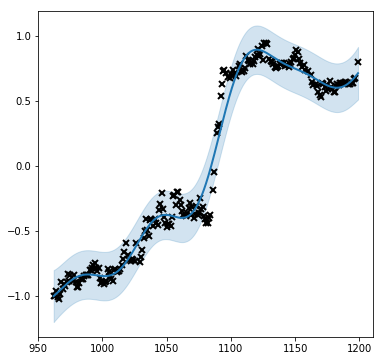

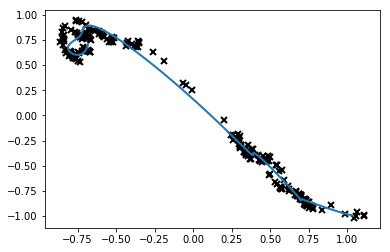

In [154]:
kl = 35.35284062499371
kv = 1.5963247503571127
lv = 0.03332870186146018
k3 = gpflow.kernels.RBF(input_dim=1,lengthscales=kl, variance=kv,ARD=False)
w=1
xa = beestX
ya = beestY
xya = np.hstack((np.expand_dims(beestX,-1),np.expand_dims(beestY,-1)))
ta = np.expand_dims(beestTime,-1)


m1 = gpflow.models.GPR(ta,xya, k3)#=m.Z.value)
m1.likelihood.variance = lv


xx = np.linspace(min(ta), max(ta), 1000).reshape(1000, 1)
mean, var = m1.predict_y(xx)
plt.figure(figsize=(6, 6))
plt.plot(ta, ya, 'kx', mew=2)

plt.plot(xx, mean[:,1], 'C0', lw=2)
plt.fill_between(xx[:,0],
                 mean[:,1] - np.sqrt(var[:,1]),
                 mean[:,1] + np.sqrt(var[:,1]),
                 color='C0', alpha=0.2)
#plt.axis('equal')
plt.show()

plt.plot(xa, ya, 'kx', mew=2)

plt.plot(mean[:,0], mean[:,1], 'C0', lw=2)

#plt.axis('equal')
plt.show()

In [155]:
mean[:,0]

array([ 1.03800286e+00,  1.03271663e+00,  1.02744805e+00,  1.02219817e+00,
        1.01696803e+00,  1.01175866e+00,  1.00657107e+00,  1.00140626e+00,
        9.96265220e-01,  9.91148936e-01,  9.86058373e-01,  9.80994484e-01,
        9.75958213e-01,  9.70950487e-01,  9.65972222e-01,  9.61024320e-01,
        9.56107668e-01,  9.51223139e-01,  9.46371592e-01,  9.41553871e-01,
        9.36770806e-01,  9.32023210e-01,  9.27311881e-01,  9.22637603e-01,
        9.18001141e-01,  9.13403247e-01,  9.08844655e-01,  9.04326082e-01,
        8.99848229e-01,  8.95411780e-01,  8.91017401e-01,  8.86665742e-01,
        8.82357434e-01,  8.78093091e-01,  8.73873310e-01,  8.69698669e-01,
        8.65569726e-01,  8.61487025e-01,  8.57451087e-01,  8.53462416e-01,
        8.49521500e-01,  8.45628803e-01,  8.41784774e-01,  8.37989842e-01,
        8.34244415e-01,  8.30548884e-01,  8.26903620e-01,  8.23308973e-01,
        8.19765275e-01,  8.16272838e-01,  8.12831954e-01,  8.09442896e-01,
        8.06105917e-01,  

In [5]:
beest1000=np.load('beest2000.npy')
##########################################################################
##          movie files and parameters
##########################################################################
DATAHOME = '/home/staff1/ctorney/data/wildebeest_front/'
inputname = DATAHOME + '/wildfront.csv'
dfMovies = pd.read_csv(inputname)


dfMovies = dfMovies[dfMovies['ir']==0]
bcount=0
##########################################################################
##          loop through movies in list
##########################################################################
allDist = np.zeros((0,1))
for index, d in dfMovies.iterrows():
    
    filename = DATAHOME + d['filename']
    direct, ext = os.path.split(filename)
    noext, _ = os.path.splitext(ext)
    inputdatafile = direct + '/proc/' +  noext + '_POS.txt'
    #warpsfile = direct + '/proc/' + noext + '_WARP.npy'
    BLfile = direct + '/proc/' +  noext + '_BL.npy'
    bodylengths = np.load(BLfile)
    data = np.genfromtxt(inputdatafile,delimiter=',') #,dtype=None, names=True)
    
    thisFile = beest1000[beest1000[:,0]==index]
    count=0
    timepoints=data[:,0]
    w_ids=(data[:,1])
    xpos = 0.5*(data[:,2]+data[:,4])
    ypos = 0.5*(data[:,3]+data[:,5])
    movieDist = np.zeros((0,1))
    for i in range(int(np.max(timepoints)//(4*60))):
        indexes = (timepoints>(i*4*60))&(timepoints<((i+1)*4*60))
        t_w_id = w_ids[indexes]
        t_tp = timepoints[indexes]
        t_xp = xpos[indexes]
        t_yp = ypos[indexes]
        beestList = beest1000[(beest1000[:,0]==index)&(beest1000[:,1]==i),2]
        for b in beestList:
            if bcount==1000: 
                break
            beestTime = t_tp[t_w_id==b]
            beestX = t_xp[t_w_id==b]
            beestY = t_yp[t_w_id==b]
            minT = int(np.min(beestTime))
            maxT = int(np.max(beestTime))
            if np.sum(bodylengths[minT:maxT]==0)>0:
                continue
            bl = bodylengths[minT]
            ibeestX = np.interp(np.arange(minT,maxT+1),beestTime,beestX)
            ibeestY = np.interp(np.arange(minT,maxT+1),beestTime,beestY)
            distance = ((ibeestX[0]/bl-ibeestX[-1]/bl)**2+(ibeestY[0]/bl-ibeestY[-1]/bl)**2)**0.5
            ts = np.arange(minT,maxT+1)
            beestArray = np.zeros((0,11))
            for ft in range(len(ts)):
                bl = bodylengths[ts[ft]]
                cx = ibeestX[ft]/bl
                cy = ibeestY[ft]/bl
                otherX = t_xp[(t_w_id!=b)&(t_tp==ts[ft])]/bl
                otherY = t_yp[(t_w_id!=b)&(t_tp==ts[ft])]/bl
                diffs = (cx-otherX)**2+(cy-otherY)**2
                if len(diffs)<5:
                    beestArray = np.zeros((0,11))
                    break
                k = 4

                idx = np.argpartition(diffs, k)
                beestArray = np.vstack((beestArray, np.hstack((bcount, cx,cy,otherX[idx[:k]].T,otherY[idx[:k]].T))))
            if len(beestArray)>0:
                movieDist = np.vstack((movieDist, [distance]))
                bcount+=1
        
    allDist = np.vstack((allDist, movieDist))
    

KeyboardInterrupt: 

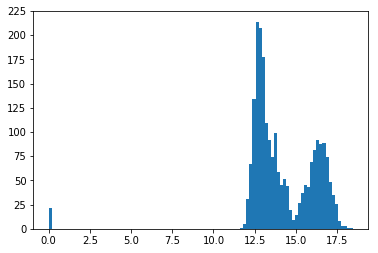

In [16]:
plt.hist(bodylengths,bins=100)
plt.show()

In [21]:
np.mean(bodylengths[2:240])

12.769532753942986

In [37]:
k

3

In [45]:
beestList=np.append(beestList,np.array([[index,w]]),axis=0)

In [75]:
beestList.shape

(301, 3)

In [71]:
np.max(timepoints)


2239.0

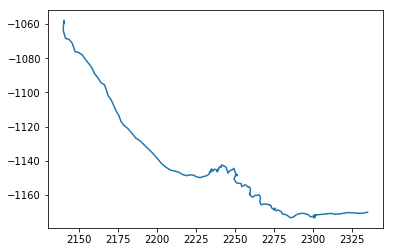

In [11]:
beest1000=np.load('beest2000.npy')
##########################################################################
##          movie files and parameters
##########################################################################
DATAHOME = '/home/staff1/ctorney/data/wildebeest_front/'
inputname = DATAHOME + '/wildfront.csv'
dfMovies = pd.read_csv(inputname)


dfMovies = dfMovies[dfMovies['ir']==0]
bcount=0
##########################################################################
##          loop through movies in list
##########################################################################
BFA = np.zeros((0,11))
for index, d in dfMovies.iterrows():
    if index!=11:
        continue
    filename = DATAHOME + d['filename']
    direct, ext = os.path.split(filename)
    noext, _ = os.path.splitext(ext)
    inputdatafile = direct + '/proc/' +  noext + '_POS.txt'
    #warpsfile = direct + '/proc/' + noext + '_WARP.npy'
    BLfile = direct + '/proc/' +  noext + '_BL.npy'
    bodylengths = np.load(BLfile)
    data = np.genfromtxt(inputdatafile,delimiter=',') #,dtype=None, names=True)
    
    
    count=0
    timepoints=data[:,0]
    w_ids=(data[:,1])
    xpos = 0.5*(data[:,2]+data[:,4])
    ypos = 0.5*(data[:,3]+data[:,5])
    
    i=0
    w=2
    plt.plot(xpos[(data[:,1]==w)&(data[:,0]>i*4*60)&(data[:,0]<(i+1)*4*60)],-ypos[(data[:,1]==w)&(data[:,0]>i*4*60)&(data[:,0]<(i+1)*4*60)])
    plt.show()
#     movieArray = np.zeros((0,11))
#     for i in range(int(np.max(timepoints)//(4*60))):
#         indexes = (timepoints>(i*4*60))&(timepoints<((i+1)*4*60))
#         t_w_id = w_ids[indexes]
#         t_tp = timepoints[indexes]
#         t_xp = xpos[indexes]
#         t_yp = ypos[indexes]
#         beestList = beest1000[(beest1000[:,0]==index)&(beest1000[:,1]==i),2]
#         for b in beestList:
#             if bcount==1000: 
#                 break
#             beestTime = t_tp[t_w_id==b]
#             beestX = t_xp[t_w_id==b]
#             beestY = t_yp[t_w_id==b]
#             minT = int(np.min(beestTime))
#             maxT = int(np.max(beestTime))
#             if np.sum(bodylengths[minT:maxT]==0)>0:
#                 continue
#             ibeestX = np.interp(np.arange(minT,maxT+1),beestTime,beestX)
#             ibeestY = np.interp(np.arange(minT,maxT+1),beestTime,beestY)
#             ts = np.arange(minT,maxT+1)
#             beestArray = np.zeros((0,11))
#             for ft in range(len(ts)):
#                 bl = bodylengths[ts[ft]]
#                 cx = ibeestX[ft]/bl
#                 cy = ibeestY[ft]/bl
#                 otherX = t_xp[(t_w_id!=b)&(t_tp==ts[ft])]/bl
#                 otherY = t_yp[(t_w_id!=b)&(t_tp==ts[ft])]/bl
#                 diffs = (cx-otherX)**2+(cy-otherY)**2
#                 if len(diffs)<5:
#                     beestArray = np.zeros((0,11))
#                     break
#                 k = 4

#                 idx = np.argpartition(diffs, k)
#                 beestArray = np.vstack((beestArray, np.hstack((bcount, cx,cy,otherX[idx[:k]].T,otherY[idx[:k]].T))))
#             if len(beestArray)>0:
#                 movieArray = np.vstack((movieArray, beestArray))
#                 bcount+=1
        
#     BFA = np.vstack((BFA, movieArray))
# np.save('BFA.npy',BFA)